# Transfer learning with VGG16

--- 

Here we use a pre-trained VGG16 model, replace and train the last layer (keep all other weights the same), and now predict our dog breeds!
Some of the code used in this notebook is in `src/models` and `src/utils`, so check out those functions to see what's going on. 

Before running this notebook, make sure the data is downloaded and put in the correct folder (see the README)

In [1]:
import random
import numpy as np
from glob import glob
from src.models import detect_faces, detect_dogs, train_model, test_model, predict_model
from src.utils import un_normalize_image

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import torch
import torchvision.transforms as transforms
from torchvision import datasets

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
TRAIN_DATA_PATH = "../data/raw/dogImages/train"
VALIDATION_DATA_PATH = "../data/raw/dogImages/valid"
TEST_DATA_PATH = "../data/raw/dogImages/test"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

## Read in data

In [5]:
random.seed(12)

# load filenames for human and dog images
human_files = np.array(glob("../data/raw/lfw/*/*"))
dog_files = np.array(glob("../data/raw/dogImages/*/*/*"))
random.shuffle(human_files)
random.shuffle(dog_files)

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [6]:
print(f"Some human files: \n{human_files[:4]}\n")
print(f"Some dog files: \n{dog_files[:4]}")

Some human files: 
['../data/raw/lfw\\Nicole_Hiltz\\Nicole_Hiltz_0001.jpg'
 '../data/raw/lfw\\Donald_Rumsfeld\\Donald_Rumsfeld_0020.jpg'
 '../data/raw/lfw\\Robbie_Coltrane\\Robbie_Coltrane_0001.jpg'
 '../data/raw/lfw\\Wolfgang_Clement\\Wolfgang_Clement_0001.jpg']

Some dog files: 
['../data/raw/dogImages\\test\\047.Chesapeake_bay_retriever\\Chesapeake_bay_retriever_03390.jpg'
 '../data/raw/dogImages\\train\\039.Bull_terrier\\Bull_terrier_02795.jpg'
 '../data/raw/dogImages\\train\\011.Australian_cattle_dog\\Australian_cattle_dog_00774.jpg'
 '../data/raw/dogImages\\train\\023.Bernese_mountain_dog\\Bernese_mountain_dog_01663.jpg']


In [7]:
breeds = [x.split('/')[3].split("\\")[3][:-10] for x in dog_files]
breeds = np.unique(breeds)
print(f"There are {len(breeds)} breeds in total\n")
print(f"example breeds: \n{breeds[:5]}")

There are 133 breeds in total

example breeds: 
['Affenpinscher' 'Afghan_hound' 'Airedale_terrier' 'Akita'
 'Alaskan_malamute']


## Look at some images and define transformations for training

Here we'll look at some raw images, and then show the transformations we'll perform on the images we train on (we'll randomly flip them, etc.. to reduce overfitting and to augment our dataset). 

For the training data, we'll use a particular data transform, which includes resizing the image, randomly rotating, scaling and translating it, slightly changing the colour, flipping horizontally with probability 0.5, and normalizing. 

We'll also have another transformation which only resizes and normalizes, this is required because the VGG16 model expects the inputs to be a certain size, and the images it trained on were normalized in a certain way. This "bare transformation" is used for the test and validation data. 

In [8]:
batch_size = 25
num_workers = 0

In [13]:
# These two transforms are used for the fine-tuning model
data_transform_bare  = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 std=[0.229, 0.224, 0.225])])

data_transform  = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.RandomAffine(degrees=10, 
                                                    translate=(0.15, 0.15), 
                                                    scale=(0.8, 1.2)),
                            transforms.ColorJitter(brightness = 0.3,
                                                  contrast = 0.5,
                                                  saturation=0.5),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 std=[0.229, 0.224, 0.225])])

# datasets
train_data = datasets.ImageFolder(TRAIN_DATA_PATH, transform=data_transform)
valid_data = datasets.ImageFolder(VALIDATION_DATA_PATH, transform=data_transform_bare)
test_data = datasets.ImageFolder(TEST_DATA_PATH, transform=data_transform_bare)

# define the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

loaders = {'train' : train_loader, 'valid' : valid_loader, 'test': test_loader}

### Look at some raw images
Here we visualize some of our raw dog images. They are all different sizes. The VGG16 model expects colour input images of size 224x224, that's why we rescale them later.

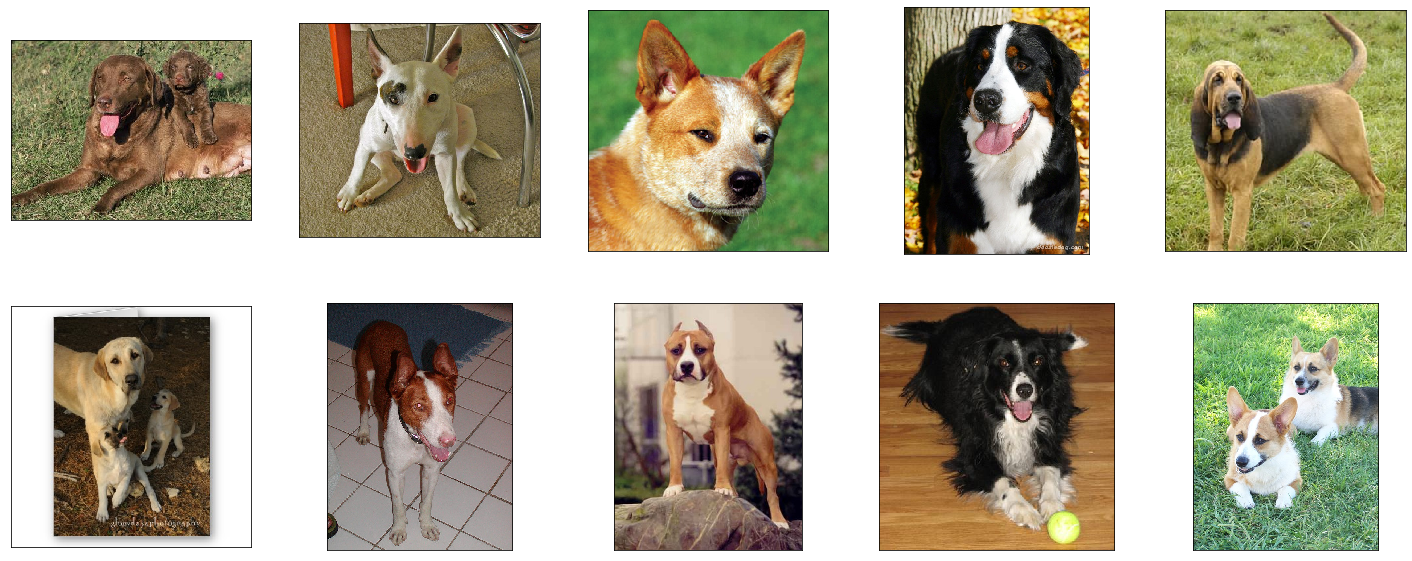

In [10]:
indices = np.random.randint(0, len(dog_files), 10)
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(10):
    image = Image.open(dog_files[idx])
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(image)

### Look at some transformed images
see if the transformations we applied (rotation, translation, etc..) are not too disturbing, it shouldn't be we cannot recognize the dogs ourselves anymore

In [11]:
# helper function to un-normalize and display an image
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
un_norm = un_normalize_image.UnNormalize()

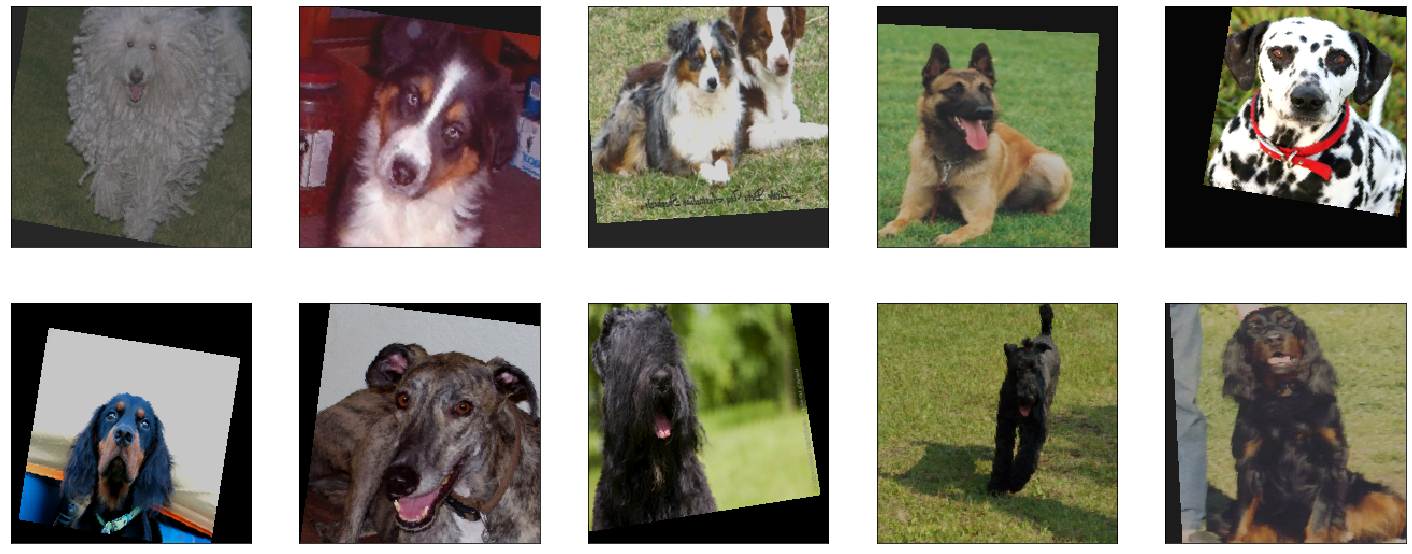

In [14]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, _ = dataiter.next()

# plot some of the images in this batch
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(10):
    # resized images
    image = un_norm(images[idx])
    image = image.numpy()    

    # show images
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(image)

---
<a id='step4'></a>
## Use transfer learning with the VGG16 model


###  Model Architecture

I took the very last layer of the VGG16 model and replaced it with a new fully connected layer with 133 outputs (as we have 133 classes). This is reasonable because the dog-breed images are not that different from the images the vgg16 model was trained on (some of the classes it was predicting were dogs as well). The weights in the earlier layers were frozen (as they are used for detection of e.g. corners and lines, etc.. ) and the weights in all the fully connected layers were re-trained. 

I got 83% accuracy by just removing the last layer, which seems pretty good.

In [15]:
# define VGG16 model
vgg16 = models.vgg16(pretrained=True)

# move model to GPU if cuda is available
if use_cuda:
    vgg16 = vgg16.cuda()

In [16]:
# shape of the orignal vgg16 classifier
in_old = vgg16.classifier[6].in_features
print(vgg16.classifier[6].out_features) 
print(in_old) 

# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False
    
# replace last layer with a new linear layer with 133 outputs (the number of classes we have)
vgg16.classifier[6] = nn.Linear(in_old, 133)
model_transfer = vgg16

if use_cuda:
    model_transfer = model_transfer.cuda()

1000
4096


### Specify loss function and optimizer


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

### Train the model


In [ ]:
# train the model
n_epochs = 100
model_transfer = train_model.train(n_epochs=n_epochs, 
                                   loaders=loaders, 
                                   model=model_transfer, 
                                   optimizer=optimizer, 
                                   criterion=criterion, 
                                   use_cuda=use_cuda, 
                                   save_path=f"../models/model_transfer_{n_epochs}.pt")
torch.cuda.empty_cache()

Starting epoch 1
	Training..


### Load in the best model

I ran the model on a gpu for about 70 epochs, and saved that model at `models/model_transfer_70.pt`, which I read in below to test it. 

In [18]:
# load the model that got the best validation accuracy (uncomment the line below)
n_epochs = 70
model_transfer.load_state_dict(torch.load(f'../models/model_transfer_{n_epochs}.pt', map_location=lambda storage, loc: storage))

<All keys matched successfully>

###  Test the Model

We see that we get about 83% accuracy with our transfer learning model. That's not too bad, considering we froze all of the earlier weights and only optimized the last new layer

In [19]:
# call test function    
test_model.test(model_transfer, criterion, use_cuda, test_data_path=TEST_DATA_PATH)

Test Loss: 0.595171
Test Accuracy: 83% (694/836)


### Predict with our model

Here we write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the model.  

In [20]:
test_dogs = np.array(glob("../data/raw/dogImages/test/*/*"))
random.shuffle(test_dogs)
test_dogs = test_dogs[:10]

Predicting for dog English_setter


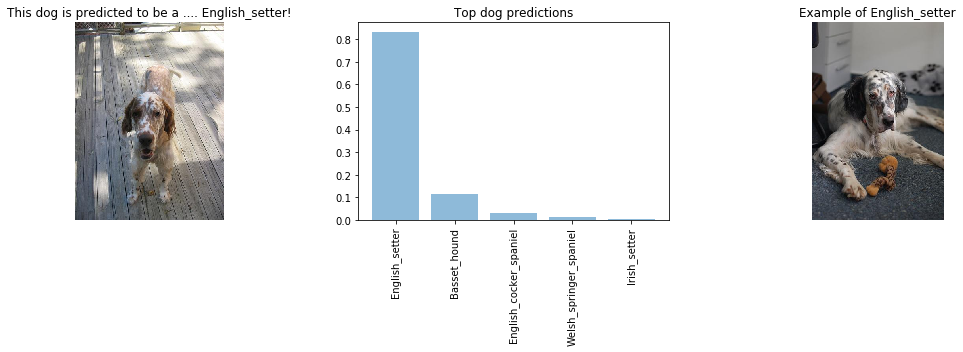

Predicting for dog Petit_basset_griffon_vendeen


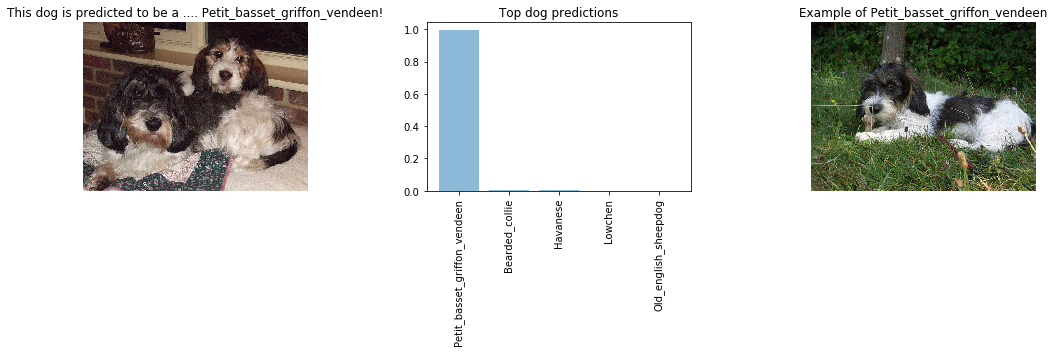

Predicting for dog Lowchen


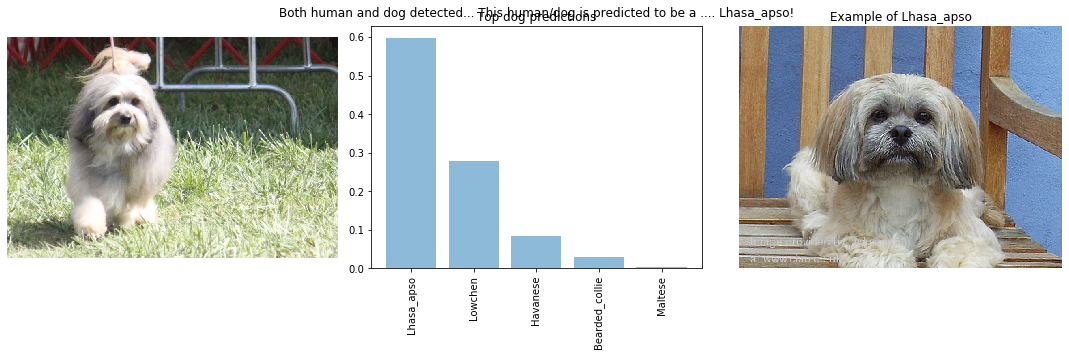

Predicting for dog Australian_terrier


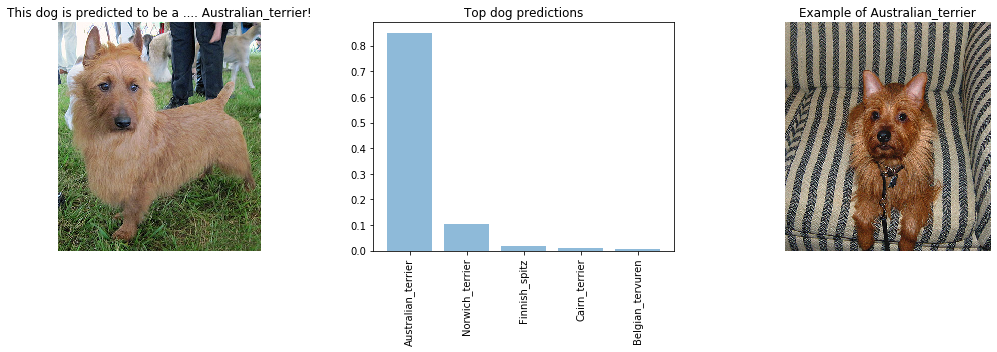

Predicting for dog Japanese_chin


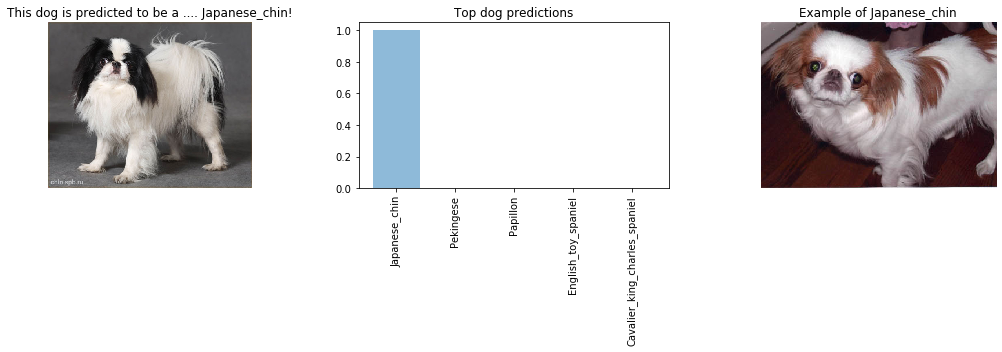

Predicting for dog Black_russian_terrier


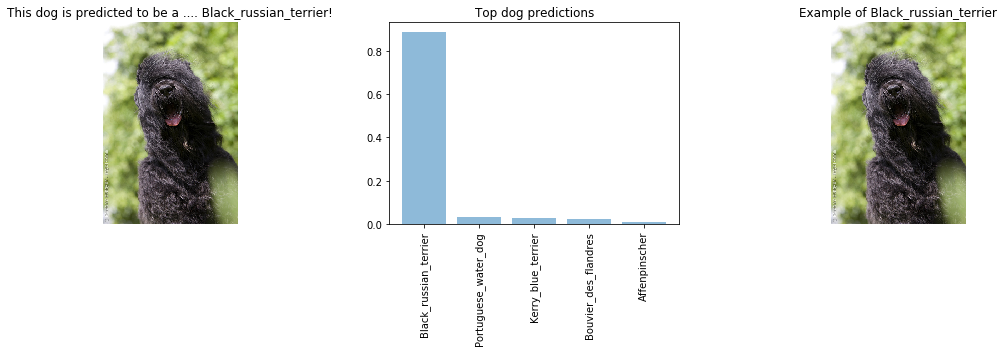

Predicting for dog Norwegian_lundehund


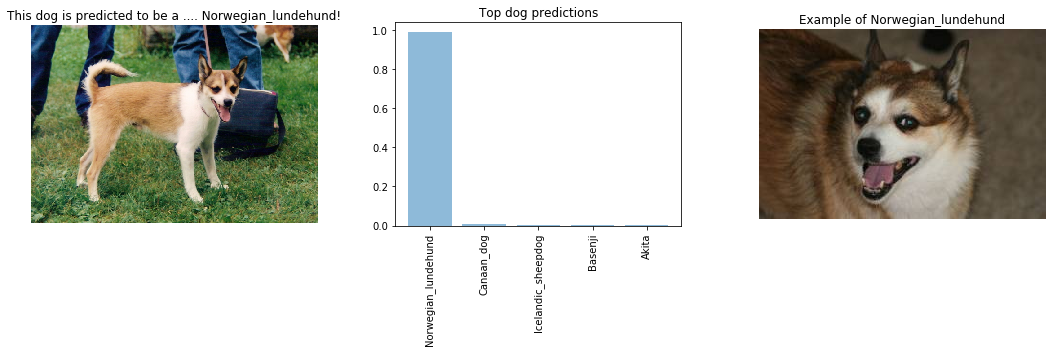

Predicting for dog Boston_terrier


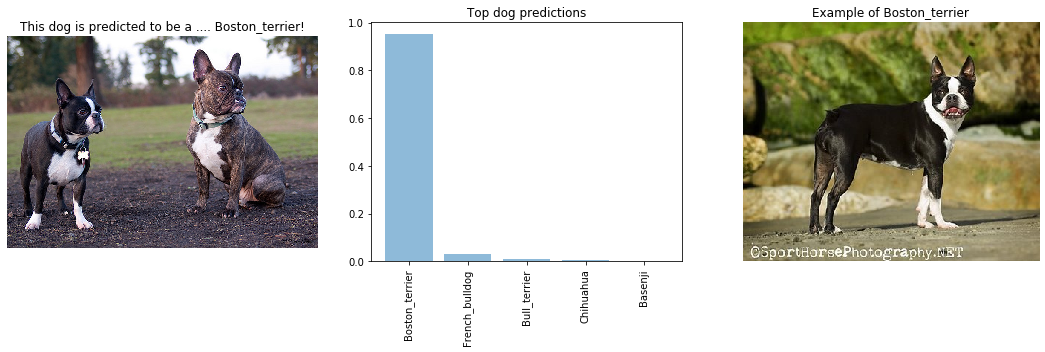

Predicting for dog Basset_hound


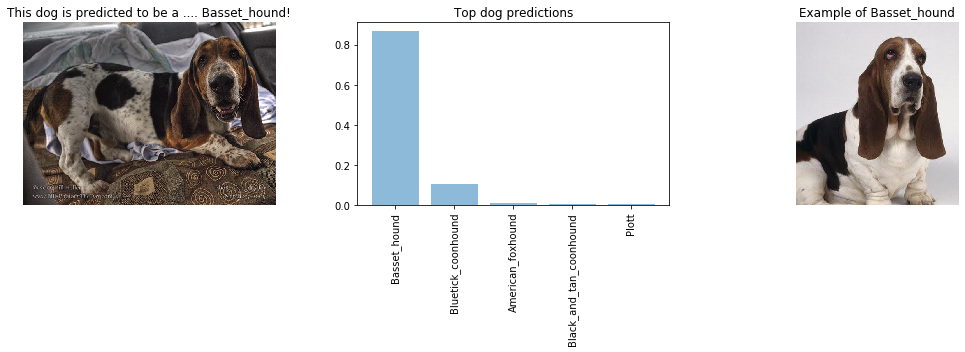

Predicting for dog French_bulldog


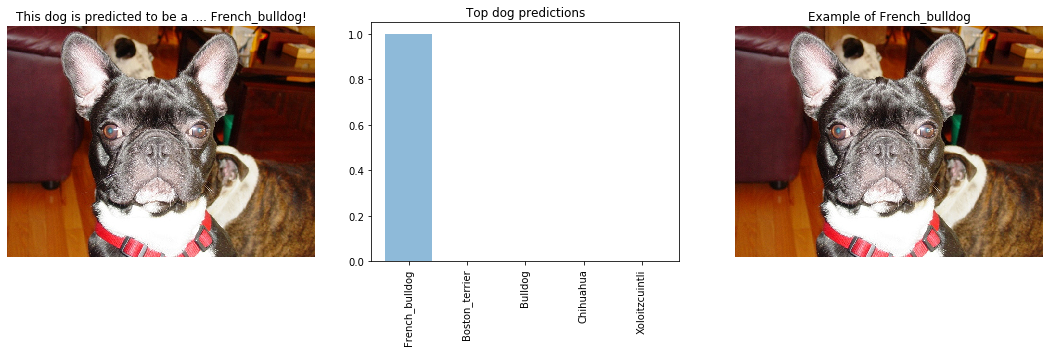

In [21]:
for dog in test_dogs:
    actual_dog = dog.split('\\')[-1][:-10]
    print(f"Predicting for dog {actual_dog}")
    predict_model.create_prediction_fig(dog, model_transfer, breeds, save_image=False,
                                        show_image=True, path_dog_files="../data/raw/dogImages/*/*/*")

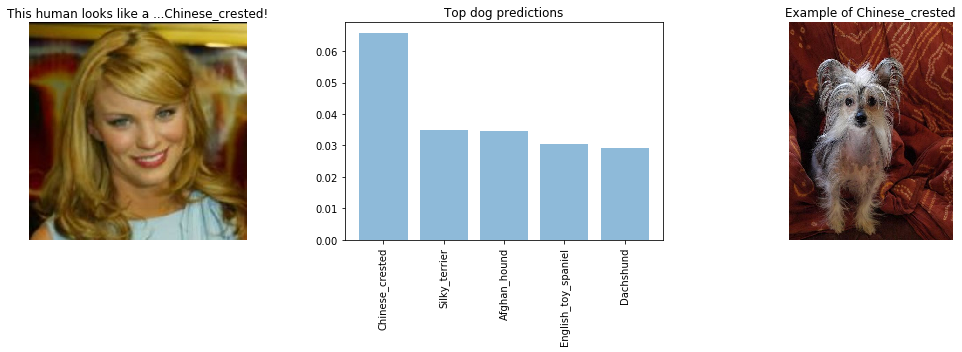

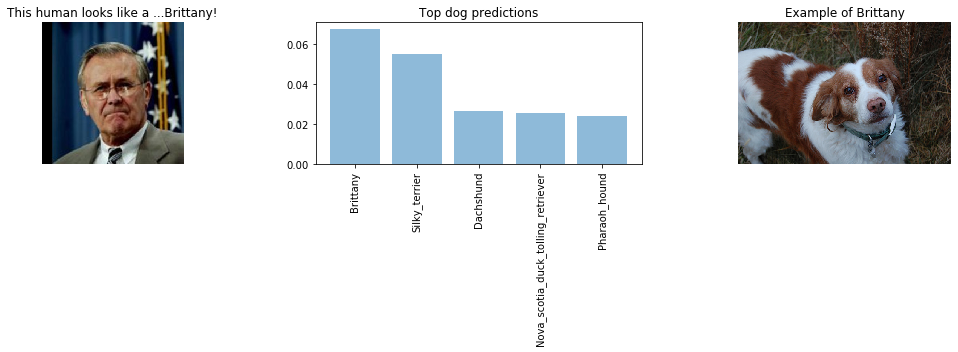

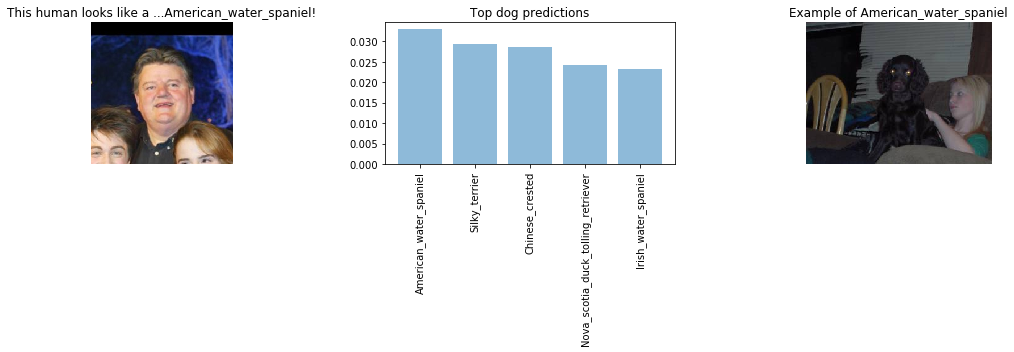

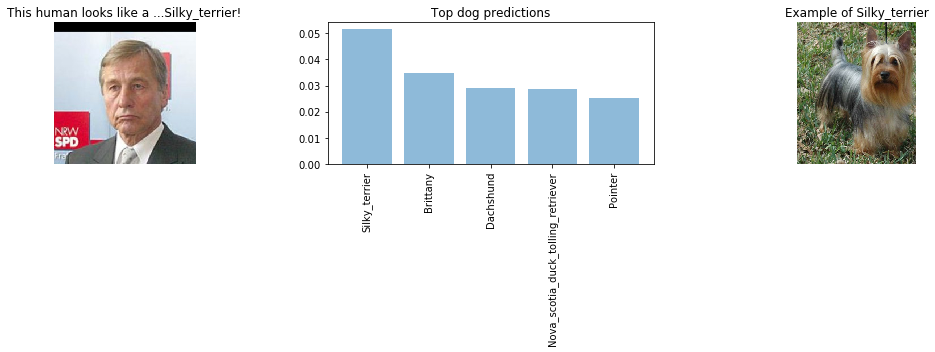

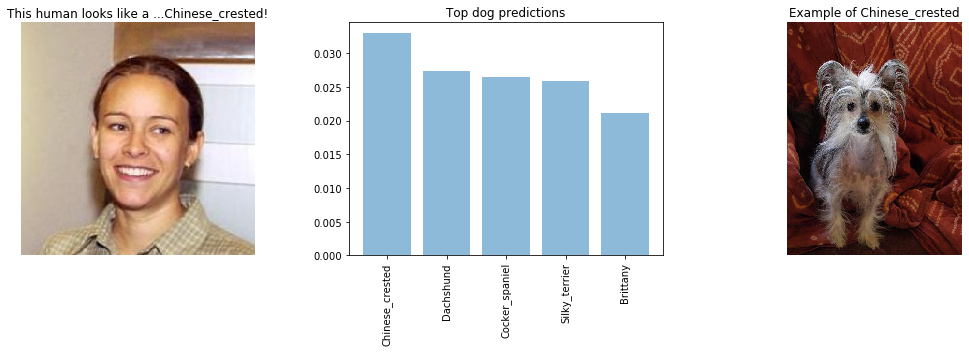

In [22]:
for human in human_files[:5]:
    predict_model.create_prediction_fig(human, model_transfer, breeds, save_image=False,
                                        show_image=True, path_dog_files="../data/raw/dogImages/*/*/*")